In [241]:
import pandas as pd
import numpy as np
import pathlib
import os
import pickle
import xgboost
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from vars import balance_numerical_features
from sklearn.model_selection import train_test_split

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

In [2]:
def clip_series(s, lower, upper):
   clipped = s.clip(lower=s.quantile(lower), upper=s.quantile(upper), axis=0)
   return clipped

# Train Test Split

In [8]:
data = pd.read_csv('../data/processed/data.csv')
data = data.dropna(subset='target')
irrelevant=[
    'symbol',
    'calendarYear',
    'date',
    'reportedCurrency',
    'cik',
    'fillingDate',
    'acceptedDate',
    'period',
    'link',
    'finalLink',
    'month',
    'inflationMultiplier',
    'mcapDate',
    'mcapYear',
    'mcapWeek',
]
data = data.drop(columns=irrelevant)

In [49]:
train, test = train_test_split(data, test_size=0.25, random_state = 46)
train.shape, test.shape

NameError: name 'data' is not defined

In [ ]:
train.to_csv('../data/processed/train.csv', index=False)
test.to_csv('../data/processed/test.csv', index=False)

# Feature Reduction
- First Regressor to get some clues into what features are important
- Baseline XGBoostRegressor model because:
  - It ignores multicolinearity: it mimics splits on correlated data
  - It ignores skeweness because it selects split thresholds between values
  - Alows to get importance by error reduction and split

In [198]:
# read train data
train = pd.read_csv('../data/processed/train.csv')

In [199]:
X_train, X_test, y_train, y_test = train_test_split(
    train.drop(columns='target'),
    train.target,
    test_size = 0.25,
    random_state=46)
[i.shape for i in [X_train, X_test, y_train, y_test]] 

[(5376, 99), (1792, 99), (5376,), (1792,)]

In [6]:
def objective(trial):
    params={
        "verbosity": 1,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": "gbtree",
        "base_score": 0.1,
        "min_child_weight": trial.suggest_int("min_child_weight", 50, 500),
        "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 3, 10),
        "gamma" : trial.suggest_int("gamma", 1, 1e3, log=True),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 1),
        "subsample" : trial.suggest_float("subsample", 0.5, 1),
        "eta" : trial.suggest_float("eta", 1e-2, 0.2, log=True)
        }
    
    # define xgb matrices
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dvalid = xgboost.DMatrix(X_test, label=y_test)
    bst = xgboost.train(
        params, 
        dtrain, 
        evals=[(dvalid, "validation")], 
        num_boost_round=2000, 
        early_stopping_rounds=20,
        verbose_eval = False, 
        callbacks=[pruning_callback]
        )
    preds = bst.predict(dvalid)
    score = mean_squared_error(y_test, preds)
    return score

minutes = 30
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=(60*minutes))
df = study.trials_dataframe()
# save to .csv
df.to_csv('../data/model_selection/XGB_trials/trial_benchmark.csv', index=False)

[I 2022-04-07 18:25:24,022] A new study created in memory with name: no-name-634fd8a6-5bdd-4957-9a0a-2a5930c7398e
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-04-07 18:26:53,374] Trial 0 finished with value: 3813.6811366239053 and parameters: {'min_child_weight': 298, 'alpha': 0.4675258184756064, 'max_depth': 5, 'gamma': 901, 'colsample_bytree': 0.5046812345416125, 'subsample': 0.950484128898029, 'eta': 0.02154706824664518}. Best is trial 0 with value: 3813.6811366239053.
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  e

In [163]:
results = pd.read_csv('../data/model_selection/XGB_trials/trial_benchmark.csv')
results = results.query("state=='COMPLETE'").sort_values(by='value')

In [164]:
idx_best = results.value.idxmin()
param_cols = [x for x in results.columns if x.startswith('params_')]
best_params = results.loc[idx_best, param_cols]
best_params.index = [x.replace('params_','') for x in best_params.index]
best_params_dict = best_params.to_dict()

In [165]:
best_params_dict

{'alpha': 5.908935137853477e-06,
 'colsample_bytree': 0.8487825331076725,
 'eta': 0.078229580770503,
 'gamma': 40,
 'max_depth': 8,
 'min_child_weight': 91,
 'subsample': 0.9972167335680384}

In [166]:
params = best_params_dict
dtrain = xgboost.DMatrix(X_train, label=y_train)
dvalid = xgboost.DMatrix(X_test, label=y_test)
bst = xgboost.train(
    params, 
    dtrain,  
    num_boost_round=2000,
    )
preds = bst.predict(dvalid)
score = mean_squared_error(y_test, preds)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [167]:
# read test data
test = pd.read_csv('../data/processed/test.csv')
dtest = xgboost.DMatrix(test.drop(columns='target'), label=test.target)
future_preds = bst.predict(dtest)
mean_squared_error(y_true=test.target, y_pred=future_preds)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


1846.9005235412794

<blockquote>Without any tansformation nor engineered features xgboost has a mean squared error of 1846 (sq_Billions), which is insane, but expected since we have just gathered, joined and done some basic cleaning of the data</blockquote>

#### Feature importances

In [168]:
row_n_splits = pd.DataFrame(bst.get_score(importance_type='weight'), index=['n_splits'])
row_total_gain = pd.DataFrame(bst.get_score(importance_type='total_gain'), index=['total_gain'])
row_avg_gain = pd.DataFrame(bst.get_score(importance_type='gain'), index=['avg_gain'])
importances = pd.concat([row_n_splits, row_total_gain, row_avg_gain]).T

In [169]:
importances = importances.sort_values(by=['avg_gain'], ascending = False)

In [170]:
importances['avg_gain_pct'] = 100*importances['avg_gain']/importances['avg_gain'].sum()
importances['total_gain_pct'] = 100*importances['total_gain']/importances['total_gain'].sum()

### Get correlation of important features

#### 10 most important

In [172]:
relevant_cols = importances[:10].index
importances[:10]

,n_splits,total_gain,avg_gain,avg_gain_pct,total_gain_pct
incomeBeforeTax,211.0,6.052029e+07,286826.000000,24.935051,20.867469
netIncome,302.0,4.710949e+07,155991.687500,13.561046,16.243409
operatingIncome,213.0,1.827949e+07,85819.195312,7.460642,6.302790
grossProfit,255.0,1.169192e+07,45850.652344,3.986000,4.031387
minorityInterest,67.0,2.910905e+06,43446.347656,3.776983,1.003684
stockBasedCompensation,562.0,1.957934e+07,34838.675781,3.028680,6.750979
ebitda,342.0,1.140300e+07,33342.105469,2.898576,3.931768
totalStockholdersEquity,221.0,6.621190e+06,29960.132812,2.604567,2.282994
operatingCashFlow,64.0,1.891941e+06,29561.580078,2.569919,0.652344
researchAndDevelopmentExpenses,730.0,1.414501e+07,19376.732422,1.684505,4.877218


<AxesSubplot:>

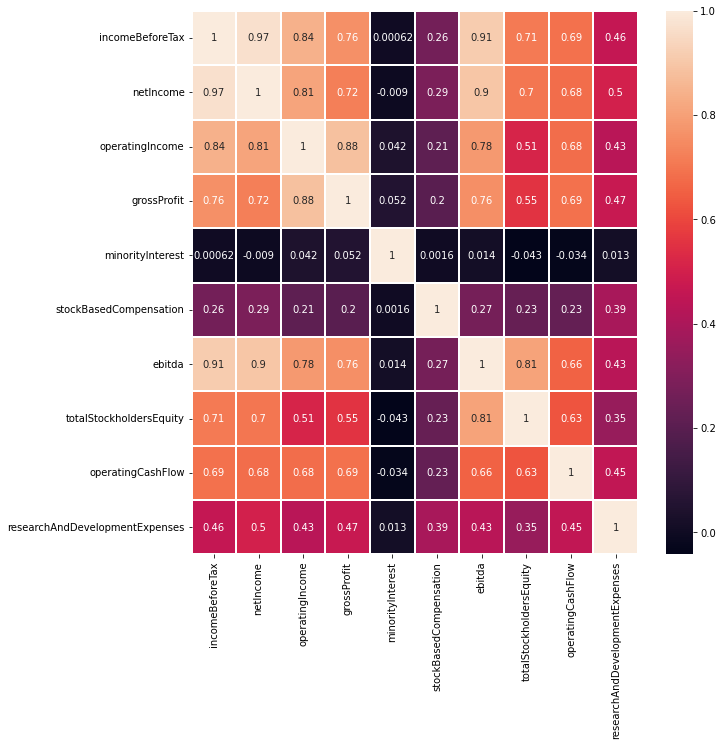

In [173]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(
    data[relevant_cols].corr(),
    linewidths=0.1,
    annot=True)

In [174]:
relevant_cols = importances[10:20].index
importances[:10]

,n_splits,total_gain,avg_gain,avg_gain_pct,total_gain_pct
incomeBeforeTax,211.0,6.052029e+07,286826.000000,24.935051,20.867469
netIncome,302.0,4.710949e+07,155991.687500,13.561046,16.243409
operatingIncome,213.0,1.827949e+07,85819.195312,7.460642,6.302790
grossProfit,255.0,1.169192e+07,45850.652344,3.986000,4.031387
minorityInterest,67.0,2.910905e+06,43446.347656,3.776983,1.003684
stockBasedCompensation,562.0,1.957934e+07,34838.675781,3.028680,6.750979
ebitda,342.0,1.140300e+07,33342.105469,2.898576,3.931768
totalStockholdersEquity,221.0,6.621190e+06,29960.132812,2.604567,2.282994
operatingCashFlow,64.0,1.891941e+06,29561.580078,2.569919,0.652344
researchAndDevelopmentExpenses,730.0,1.414501e+07,19376.732422,1.684505,4.877218


<AxesSubplot:>

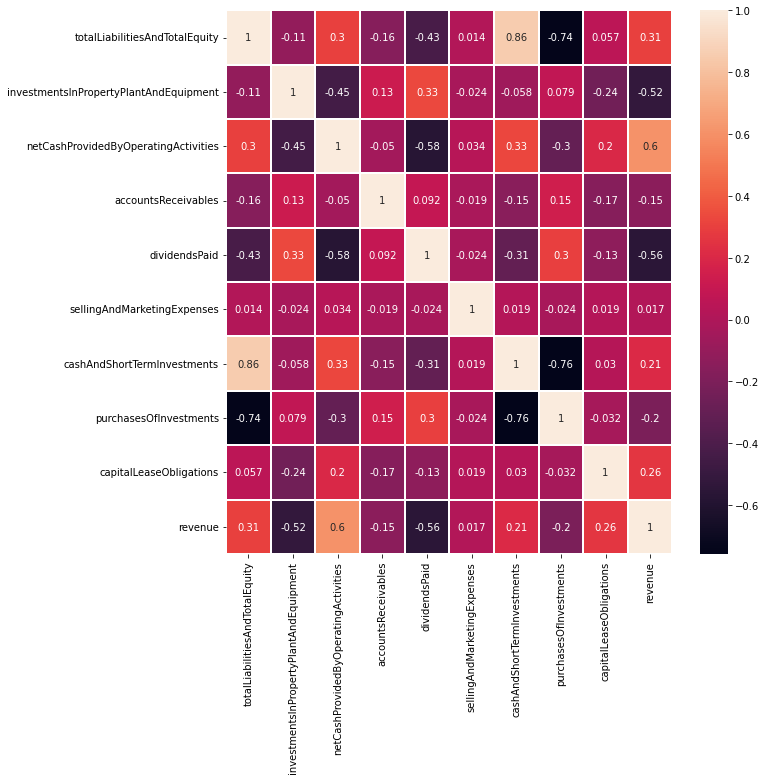

In [175]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(
    data[relevant_cols].corr(),
    linewidths=0.1,
    annot=True)

In [176]:
relevant_cols = importances[20:30].index
importances[:10]

,n_splits,total_gain,avg_gain,avg_gain_pct,total_gain_pct
incomeBeforeTax,211.0,6.052029e+07,286826.000000,24.935051,20.867469
netIncome,302.0,4.710949e+07,155991.687500,13.561046,16.243409
operatingIncome,213.0,1.827949e+07,85819.195312,7.460642,6.302790
grossProfit,255.0,1.169192e+07,45850.652344,3.986000,4.031387
minorityInterest,67.0,2.910905e+06,43446.347656,3.776983,1.003684
stockBasedCompensation,562.0,1.957934e+07,34838.675781,3.028680,6.750979
ebitda,342.0,1.140300e+07,33342.105469,2.898576,3.931768
totalStockholdersEquity,221.0,6.621190e+06,29960.132812,2.604567,2.282994
operatingCashFlow,64.0,1.891941e+06,29561.580078,2.569919,0.652344
researchAndDevelopmentExpenses,730.0,1.414501e+07,19376.732422,1.684505,4.877218


<AxesSubplot:>

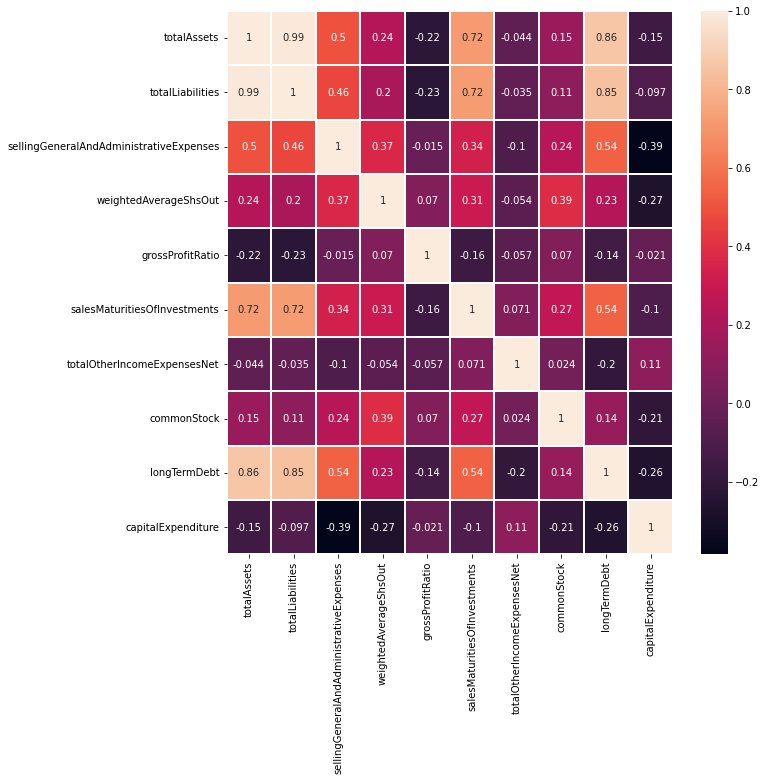

In [177]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(
    data[relevant_cols].corr(),
    linewidths=0.1,
    annot=True)

<blockquote>There is huge multicollinearity between features in the income statement, this makes sense since most of the features are linear combination of the others. This does not, in principle, affect the predictions of the boosting algorithm, but it does distort the importance of the feature.
To fix these issues we've done some research on typical financial ratios used in the finance industry, the next step is to generate them</blockquote>

# First Model
- Add relevant ratios (to reduce correlation) and keep only relevant absolute features
- Add yoy increases

In [201]:
def generate_features(data):
    features = pd.DataFrame()
    # ratios from https://corporatefinanceinstitute.com/resources/knowledge/finance/financial-ratios/
    # LIQUIDITY RATIOS
    # current ratio
    # a company’s ability to pay off short-term liabilities with current assets
    features['currentRatio'] = data.totalCurrentAssets / data.totalCurrentLiabilities
    # acid-test ratio
    # a company’s ability to pay off short-term liabilities with quick assets
    features['acidTestRatio'] = (data.totalCurrentAssets - data.inventory)/data.totalCurrentLiabilities
    # cash ratio
    # a company’s ability to pay off short-term liabilities
    features['cashRatio'] = data.cashAndCashEquivalents / data.totalCurrentLiabilities
    # operating cash flow ratio
    # number of times a company can pay off current liabilities with the cash generated in a given period
    features['operatingCashFlowRatio'] = data.operatingCashFlow / data.totalCurrentLiabilities
    # LEVERAGE FINANCIAL RATIOS
    # debt ratio
    # relative amount of a company’s assets that are provided from debt
    features['debtRatio'] = data.totalLiabilities / data.totalAssets
    # debt to equity ratio
    # weight of total debt and financial liabilities against shareholders equity
    features['debtToEquityRatio'] = data.totalLiabilities / data.totalStockholdersEquity
    # interest coverage ratio
    # how easily a company can pay its interest expenses
    features['interestCoverageRatio'] = data.operatingIncome / data.interestExpense
    # debt service coverage ratio
    #  how easily a company can pay its debt obligations
    features['debtServiceCoverageRatio'] = data.operatingIncome/data.debtRepayment
    # EFFICIENCY RATIOS
    # asset turnover ratio
    # a company’s ability to generate sales from assets
    avg_total_assets = data.groupby('symbol').totalAssets.rolling(2).mean().reset_index(0,drop=True)
    features['assetTurnoverRatio'] = data.revenue / avg_total_assets
    # inventory turnover ratio
    #  how many times a company’s inventory is sold and replaced over a given period
    avg_inventory = data.groupby('symbol').inventory.rolling(2).mean().reset_index(0,drop=True)
    features['inventoryTurnoverRatio'] = data.costOfRevenue/avg_inventory
    # daysales in inventory ratio
    # average number of days that a company holds on to inventory before selling it to customers
    features['daysSalesInventoryRatio'] = 365/features['inventoryTurnoverRatio']
    # PROFITABILITY
    # Gross profit ratio
    # how much profit a company makes after paying its cost of goods sold
    features['grossProfitRatio'] = data.grossProfitRatio
    # Operating Income ratio
    # operating income of a company to its net sales to determine operating efficiency
    features['operatingIncomeRatio'] = data.operatingIncomeRatio
    # return on assets ratio
    # how efficiently a company is using its assets to generate profit
    features['returnOnAssetsRatio'] = data.netIncome/data.totalAssets
    # return on equity ratio
    # how efficiently a company is using its equity to generate profit
    features['returnOnEquityRatio'] = data.netIncome / data.totalStockholdersEquity
    # VERTICAL ANALYSIS OF INCOME
    features['revenue'] = data.revenue
    features['costOfRevenueRatio'] = data.costOfRevenue / data.revenue
    features['researchAndDevelopmentExpensesRatio'] = data.researchAndDevelopmentExpenses / data.revenue
    features['sellingGeneralAndAdministrativeExpensesRatio'] = data.sellingGeneralAndAdministrativeExpenses / data.revenue
    features['interestExpenseRatio'] = data.interestExpense / data.revenue
    features['incomeBeforeTaxRatio'] = data.incomeBeforeTax / data.revenue
    features['incomeTaxExpenseRatio'] = data.incomeTaxExpense / data.revenue
    features['netIncomeRatio'] = data.netIncome / data.revenue
    features['netIncome'] = data.netIncome
    # HORIZONTAL ANALYSIS of the income statement
    features['revenue_yoy'] = data.groupby('symbol').revenue.pct_change(1)
    features['costOfRevenue_yoy'] = data.groupby('symbol').costOfRevenue.pct_change(1)
    features['researchAndDevelopmentExpenses_yoy'] = data.groupby('symbol').researchAndDevelopmentExpenses.pct_change(1)
    features['sellingGeneralAndAdministrativeExpenses_yoy'] = data.groupby('symbol').sellingGeneralAndAdministrativeExpenses.pct_change(1)
    features['interestExpense_yoy'] = data.groupby('symbol').interestExpense.pct_change(1)
    features['incomeBeforeTax_yoy'] = data.groupby('symbol').incomeBeforeTax.pct_change(1)
    features['incomeTaxExpense_yoy'] = data.groupby('symbol').incomeTaxExpense.pct_change(1)
    features['netIncome_yoy'] = data.groupby('symbol').netIncome.pct_change(1)
    # VERTICAL ANALYSIS OF CASH FLOW
    # Cash flow from Operating Activities CFO
    features['CFO'] = data['netCashProvidedByOperatingActivities']
    features['depreciationAndAmortizationRatio'] = data.depreciationAndAmortization / data.netCashProvidedByOperatingActivities
    features['stockBasedCompensationRatio'] = data.stockBasedCompensation / data.netCashProvidedByOperatingActivities
    features['changeInWorkingCapitalRatio'] = data.changeInWorkingCapital / data.netCashProvidedByOperatingActivities
    # Cash flow from Investing Activities CFI
    features['CFI'] = data['netCashUsedForInvestingActivites']
    features['capitalExpenditurePctSales'] = data.capitalExpenditure / data.revenue
    features['capitalExpenditureRatio'] = data.capitalExpenditure / data.netCashUsedForInvestingActivites
    # Free Cash flow
    features['freeCashFlow'] = data['freeCashFlow']
    features['freeCashFlowRatio'] = data.freeCashFlow / data.revenue
    # Cash flow from Financial Activities CFF
    features['CFF'] = data.netCashUsedProvidedByFinancingActivities
    features['TotalSpentRepurchase'] = data.commonStockRepurchased - data.commonStockIssued
    features['dividendsPaid'] = data['dividendsPaid']
    features['repurchaseDividendsRatio'] = (features['TotalSpentRepurchase'] + features['dividendsPaid'])/features['freeCashFlow']
    # HORIZONTAL ANALYSIS CASH FLOW
    features['freeCashFlow_yoy'] =  data.groupby('symbol').freeCashFlow.pct_change(1)
    features['capitalExpenditure_yoy'] =  data.groupby('symbol').capitalExpenditure.pct_change(1)
    features['CFI_yoy'] = data.groupby('symbol').netCashProvidedByOperatingActivities.pct_change(1)
    return features



In [221]:
# read train data
data = pd.read_csv('../data/processed/data.csv')
data = data.dropna(subset=['target'])

In [222]:
# tranform and replace infinities with nans
features = generate_features(data).replace([np.inf, -np.inf], np.nan)
target = data.target

In [223]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size = 0.25,
    random_state=46)
[i.shape for i in [X_train, X_test, y_train, y_test]] 

[(7168, 48), (2390, 48), (7168,), (2390,)]

In [224]:
def objective(trial):
    params={
        "verbosity": 1,
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": "gbtree",
        "base_score": 0.1,
        "min_child_weight": trial.suggest_int("min_child_weight", 50, 500),
        "alpha": trial.suggest_float("alpha", 1e-6, 1.0, log=True),
        "max_depth" : trial.suggest_int("max_depth", 3, 10),
        "gamma" : trial.suggest_int("gamma", 1, 1e3, log=True),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 1),
        "subsample" : trial.suggest_float("subsample", 0.5, 1),
        "eta" : trial.suggest_float("eta", 1e-2, 0.2, log=True)
        }
    
    # define xgb matrices
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dvalid = xgboost.DMatrix(X_test, label=y_test)
    bst = xgboost.train(
        params, 
        dtrain, 
        evals=[(dvalid, "validation")], 
        num_boost_round=2000, 
        early_stopping_rounds=20,
        verbose_eval = False, 
        callbacks=[pruning_callback]
        )
    preds = bst.predict(dvalid)
    score = mean_squared_error(y_test, preds)
    return score

minutes = 15
study = optuna.create_study(direction='minimize')
study.optimize(objective, timeout=(60*minutes))
df = study.trials_dataframe()
# save to .csv
df.to_csv('../data/model_selection/XGB_trials/trial_first.csv', index=False)

[I 2022-04-08 02:41:42,589] A new study created in memory with name: no-name-53f32417-a55e-4843-968f-ed0fefc065a0
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
[I 2022-04-08 02:41:53,779] Trial 0 finished with value: 3463.089444560093 and parameters: {'min_child_weight': 342, 'alpha': 0.06352451089439516, 'max_depth': 3, 'gamma': 21, 'colsample_bytree': 0.6429705121392816, 'subsample': 0.8496752636701772, 'eta': 0.06721442286700968}. Best is trial 0 with value: 3463.089444560093.
C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  el

Get best estimator, fit it and get importances

In [225]:
results = pd.read_csv('../data/model_selection/XGB_trials/trial_first.csv')
results = results.query("state=='COMPLETE'").sort_values(by='value')
idx_best = results.value.idxmin()
param_cols = [x for x in results.columns if x.startswith('params_')]
best_params = results.loc[idx_best, param_cols]
best_params.index = [x.replace('params_','') for x in best_params.index]
best_params_dict = best_params.to_dict()

In [226]:
params = best_params_dict
dtrain = xgboost.DMatrix(X_train, label=y_train)
dvalid = xgboost.DMatrix(X_test, label=y_test)
bst = xgboost.train(
    params, 
    dtrain,  
    num_boost_round=2000,
    )
preds = bst.predict(dvalid)
score = mean_squared_error(y_test, preds)

C:\Users\fpala\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [242]:
with open('../model/benchamrk_XGBoost.pickle', 'wb') as f:
    pickle.dump(bst, f)

In [ ]:
score

1846.6935655027378

In [227]:
row_n_splits = pd.DataFrame(bst.get_score(importance_type='weight'), index=['n_splits'])
row_total_gain = pd.DataFrame(bst.get_score(importance_type='total_gain'), index=['total_gain'])
row_avg_gain = pd.DataFrame(bst.get_score(importance_type='gain'), index=['avg_gain'])
importances = pd.concat([row_n_splits, row_total_gain, row_avg_gain]).T

In [238]:
importances = importances.sort_values('avg_gain', ascending=False)
importances['avg_gain_pct'] = 100*importances['avg_gain']/importances['avg_gain'].sum()
importances['total_gain_pct'] = 100*importances['total_gain']/importances['total_gain'].sum()

In [240]:
importances[:30]

,n_splits,total_gain,avg_gain,avg_gain_pct,total_gain_pct
researchAndDevelopmentExpenses_yoy,274.0,1.276579e+07,46590.484375,19.817155,5.440587
netIncome,1922.0,8.912706e+07,46372.042969,19.724242,37.984600
CFO,1850.0,5.388038e+07,29124.531250,12.388052,22.963001
stockBasedCompensationRatio,472.0,4.956520e+06,10501.101562,4.466619,2.112393
sellingGeneralAndAdministrativeExpensesRatio,494.0,3.839972e+06,7773.222168,3.306322,1.636538
grossProfitRatio,278.0,2.055861e+06,7395.182617,3.145524,0.876177
debtServiceCoverageRatio,342.0,2.191609e+06,6408.212891,2.725719,0.934030
daysSalesInventoryRatio,270.0,1.484557e+06,5498.360840,2.338715,0.632696
researchAndDevelopmentExpensesRatio,175.0,8.355379e+05,4774.502441,2.030824,0.356094
revenue,2319.0,1.048730e+07,4522.337402,1.923566,4.469528


Top10 features.
It seems it still prefers netIncome over a lot of other metrics, which makes sense. The operating cash flow takes net income as a starting point and as we can see below they are highly correlated so we'll consider dropping it

In [239]:
relevant_cols = importances[:10].index
importances[:10]

,n_splits,total_gain,avg_gain,avg_gain_pct,total_gain_pct
researchAndDevelopmentExpenses_yoy,274.0,1.276579e+07,46590.484375,19.817155,5.440587
netIncome,1922.0,8.912706e+07,46372.042969,19.724242,37.984600
CFO,1850.0,5.388038e+07,29124.531250,12.388052,22.963001
stockBasedCompensationRatio,472.0,4.956520e+06,10501.101562,4.466619,2.112393
sellingGeneralAndAdministrativeExpensesRatio,494.0,3.839972e+06,7773.222168,3.306322,1.636538
grossProfitRatio,278.0,2.055861e+06,7395.182617,3.145524,0.876177
debtServiceCoverageRatio,342.0,2.191609e+06,6408.212891,2.725719,0.934030
daysSalesInventoryRatio,270.0,1.484557e+06,5498.360840,2.338715,0.632696
researchAndDevelopmentExpensesRatio,175.0,8.355379e+05,4774.502441,2.030824,0.356094
revenue,2319.0,1.048730e+07,4522.337402,1.923566,4.469528


<AxesSubplot:>

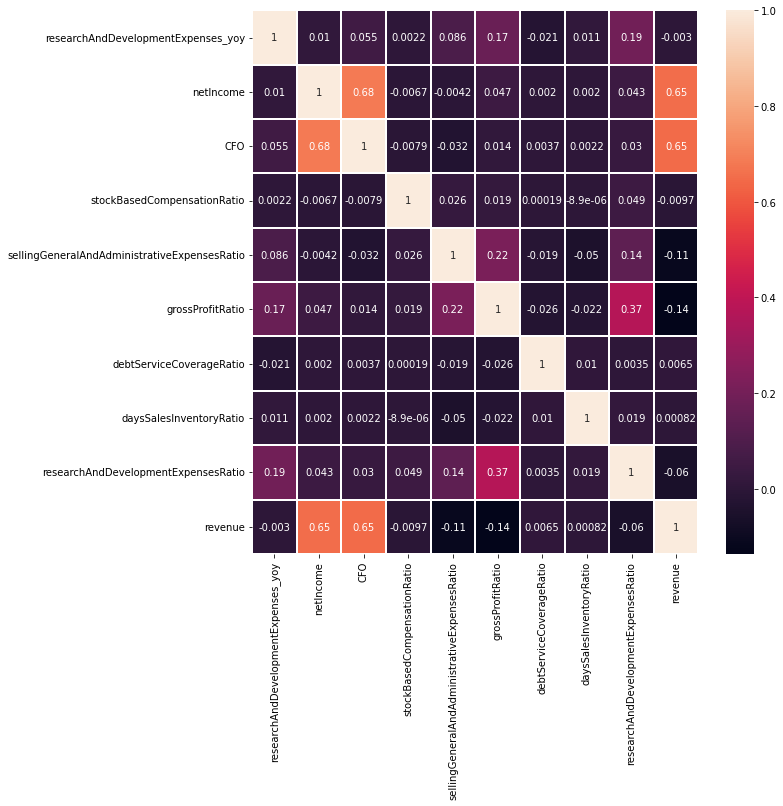

In [235]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(
    features[relevant_cols].corr(),
    linewidths=0.1,
    annot=True)

In [236]:
relevant_cols = importances[10:20].index

,n_splits,total_gain,avg_gain
researchAndDevelopmentExpenses_yoy,274.0,1.276579e+07,46590.484375
netIncome,1922.0,8.912706e+07,46372.042969
CFO,1850.0,5.388038e+07,29124.531250
stockBasedCompensationRatio,472.0,4.956520e+06,10501.101562
sellingGeneralAndAdministrativeExpensesRatio,494.0,3.839972e+06,7773.222168
grossProfitRatio,278.0,2.055861e+06,7395.182617
debtServiceCoverageRatio,342.0,2.191609e+06,6408.212891
daysSalesInventoryRatio,270.0,1.484557e+06,5498.360840
researchAndDevelopmentExpensesRatio,175.0,8.355379e+05,4774.502441
revenue,2319.0,1.048730e+07,4522.337402


Next 10 features

<AxesSubplot:>

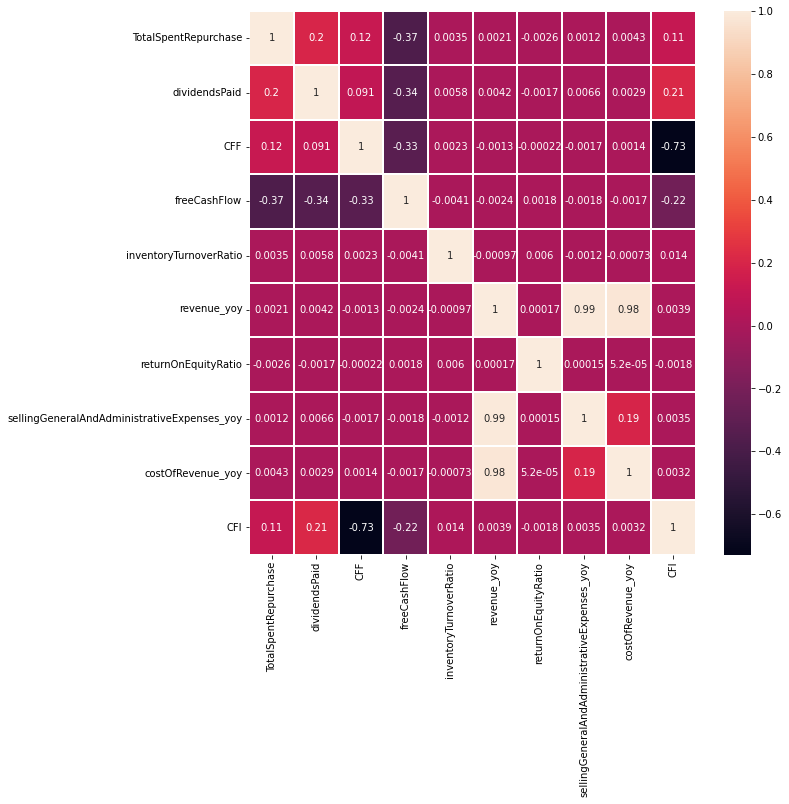

In [237]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(
    features[relevant_cols].corr(),
    linewidths=0.1,
    annot=True)